### Disclaimer- Time Series packages in Python aren't very reliable. Below I am performing time series related stuff in Python but when applied it for forecasting, the results were very unreliable and I ended up using rpy2, for calling Time Series packages and perform forecasting and all via R.

### I'll upload the rpy2 version in the next post

## Univariate Time Series Analysis in Python

### ARIMA and SARIMA

#### Before going through the code and how to perform Time Series Forecasting, I'd highly recommend you to go through the Univariate Time Series Documentation provided to you

#### Now, first and foremost thing that we will do is load the required preliminary packages in python.

- 1. **Numpy and Pandas*** are for handling the data and make required modifications to it

- 2. **Matplotlib and Seaborn** assist us in Visualizing our results and for EDA

- 3. **Statsmodels** contains numerous statistical functions and specially it's ts module will be mostly used for Time Series Analysis

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
sns.set()

#### Below we are setting some common plot styles all around the notebook

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'

### Now for each type of Plots that we are going to use for our Time Series Analysis, we fix their specific styles using functions

In [3]:
# Predefined plots

# Time series plot
def ts_plot(y, color=red):
    fig, ax= plt.subplots(figsize=(9,6))
    y.plot(color=color, ax=ax)
    ax.set_xlabel('')
    ax.set_xticks([], minor=True)
    sns.despine()
    return fig, ax

# ACF and PACF plots
def acf_pacf_plot(y):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
    sns.despine()
    fig.tight_layout()
    return fig, ax

#Histogram
def hist(y):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(y, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

## Importing the data: CO2 PPM Data from

In [5]:
data=pd.read_csv('CO2PPM.csv', index_col='Month', parse_dates=True, dayfirst=True)
data.index=data.index.to_period()
y=data['co2ppm']
data.head()

,co2ppm
Month,
1965-01,319.32
1965-02,320.36
1965-03,320.82
1965-04,322.06
1965-05,322.17


## This is how our Time Series looks like

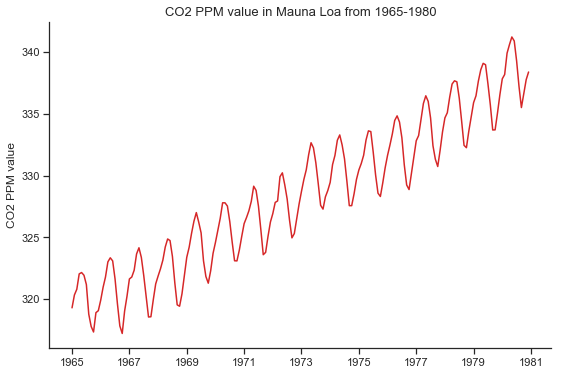

In [6]:
fig, ax= ts_plot(y)
ax.set_ylabel('CO2 PPM value')
ax.set_title('CO2 PPM value in Mauna Loa from 1965-1980', fontsize=13)
plt.show()

### Next step is to decompose the Time Series to see it's various components i.e. Trend, Seasonality and the remainder part.

### Decomposing is of various type as you might have seen in the Time Series Documentation as well. Rather than using a Naive approach(classical decomposition), let's use some advanced technique. For our analysis we will use STL decompose.

### We perform STL decomposition in Python using x13_arima_analysis module in statsmodels library

#### Now here a small issue in using this library. Due to licencing issue, statsmodels directly doesn't use this package. So first thing we need to do is download the file and save it in the current directory. You can see below:

#### One can download this file from https://www.census.gov/ts/x13as/pc/x13as_V1.1_B39.zip , extract it and save the x13as.exe file in the current directory

In [7]:
ts=y.copy()
ts.index=ts.index.to_timestamp() # remember that the decomposition functions only work with datetime
decomposition=sm.tsa.x13_arima_analysis(ts)
seasonal=decomposition.observed-decomposition.seasadj

### What we see above is that x13_arima_analysis performs the decomposition and get following useful results:

- 1. **observed**- the original data
- 2. **seasadj**- seasonaly adjusted data i.e. data after removing seasonality(remember: it does contain remainder values i.e. irregularities)
- 3. **trend**- the trend of our time series(usually calculating via moving average)
- 4. **irregular**- the remainder term after removing seasonality and trend from our data

### NOTE:- The seasonal part can easily be retrieved by subtracting seasonaly adjusted data from our original data(observed). But point to note here is, that here we saw above that our time series didn't have multiplicative seasonality i.e. it didn't increase with time. If in case that does happen, remember that in that case we will divide our observed by seasonaly adjusted values and not subtract it. Don't forget this.

### Now x13_arima_analysis has it's own plotting function under the hood but well, see yourself how the results look like:

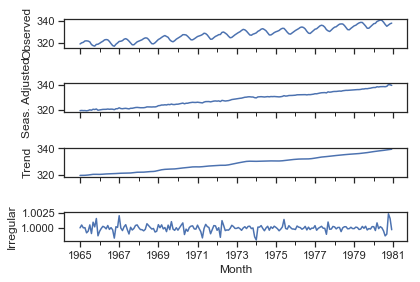

In [9]:
decomposition.plot();

### Now moreover, as we see the docomposition doesn't give us the seasonal part, which actually is just observed- seasadj part, so that too doesn't show in our result.

### So just for that purpose we define a function which performs all these plots for us and give it as result

### Here it is and it's results:

In [10]:
def plotdecomp(y):

    plt.figure(figsize=(14,10)).suptitle('Results from STL Decomposition', fontsize=20)
    #figure.suptitle('Results from STL Decomposition', fontsize=16)

# Actual
    plt.subplot(221)
    plt.plot(y.observed,color='green')
    plt.title('Actual Data',fontsize=15)
    plt.grid(True)


# Trend
    plt.subplot(222)
    plt.plot(y.trend,color='orange')
    plt.title('Trend in our Time Series',fontsize=15)
    plt.grid(True)


# Seasonality
    seasonal=y.observed/y.seasadj
    plt.subplot(223)
    plt.plot(seasonal,color='blue')
    plt.title('Seasonality',fontsize=15)
    plt.grid(True)

# Irregularities
    plt.subplot(224)
    plt.plot(y.irregular,color='brown')
    plt.title('Remainder Irregularities',fontsize=15)
    plt.grid(True)

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

    plt.show()

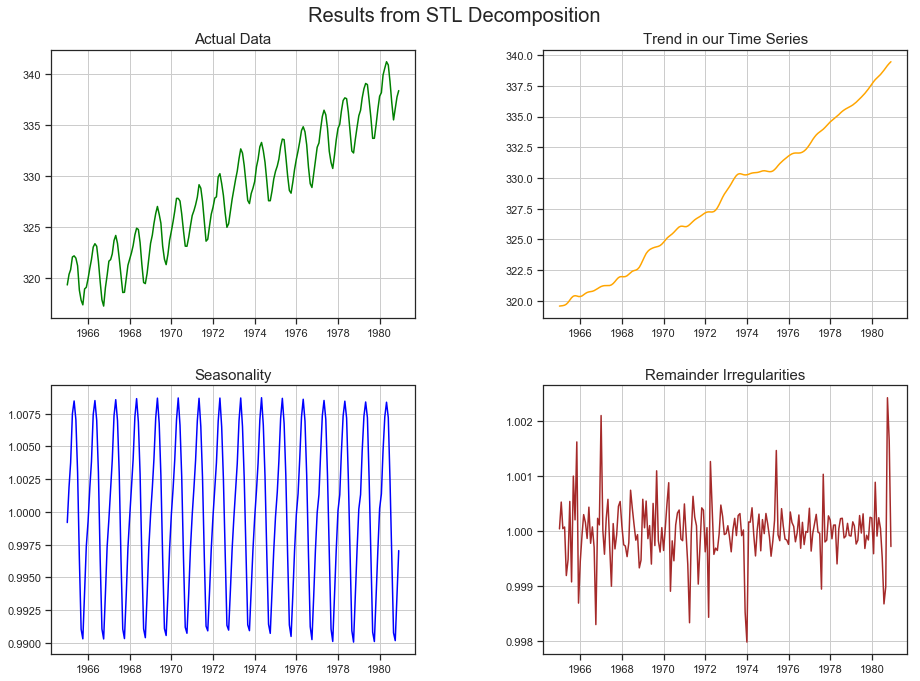

In [11]:
plotdecomp(decomposition)

To better understand the seasonal pattern, the next cell draws a seasonal plot. The number of journeys peaks in March, May and August, and is lowest during the summer months.

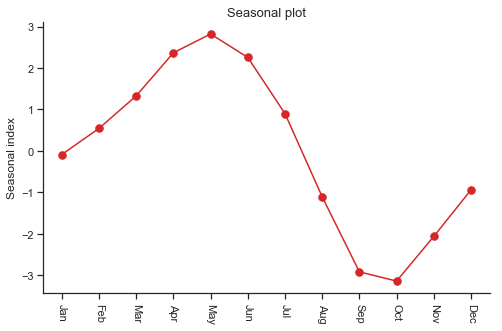

In [12]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(seasonal.groupby(seasonal.index.month).mean(), color=red, marker='.', markersize=15)
ax.set_xlim(0.5,12.5)
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months, rotation='-90')
ax.set_ylabel('Seasonal index')
ax.set_title('Seasonal plot', fontsize=13)
sns.despine()
plt.show()

### So now we can just pass the decomposed timeseries to this function and we will get these results.

### Now coming to the analysis and forecasting part.

### We are going to talk about ARIMA and seasonal ARIMA. For performing both, we need to know the value of how many AutoRegressive term(p) and how many Moving Average term(q) are needed to be taken in our model. But even before that, we need to see if our time series is stationary or not and we also need to perform first differencing(or second too) and seasonal differencing to make it stationary.

### So let's begin

### Now we already know that this time series is not stationary, but usually the best suggestion is to perform Dicky Fuller test to see if our time series is stationary or not

#### Now the null hypothesis of this test states that our time series is non- stationary. So for our time-series to be stationary, we need p-value to be <0.05.

#### We again create a function for performing the test and get readable results:

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics for seeing visually
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics to see if the result is stationary or not:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### So let's pass our Time Series and see the results

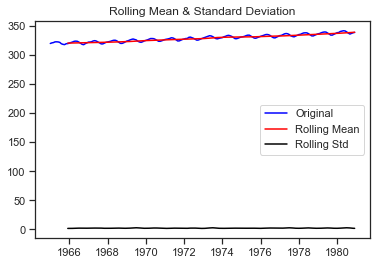

Results of Dickey-Fuller Test:
Test Statistic                   1.269677
p-value                          0.996434
#Lags Used                      12.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


In [15]:
test_stationarity(ts)

### It shows that p-value is very high and that is our Time Series is Non-Stationary, i.e. there is some trend or seasonality in our time series values.

### Let's also see the ACF and PACF plots of this time series data

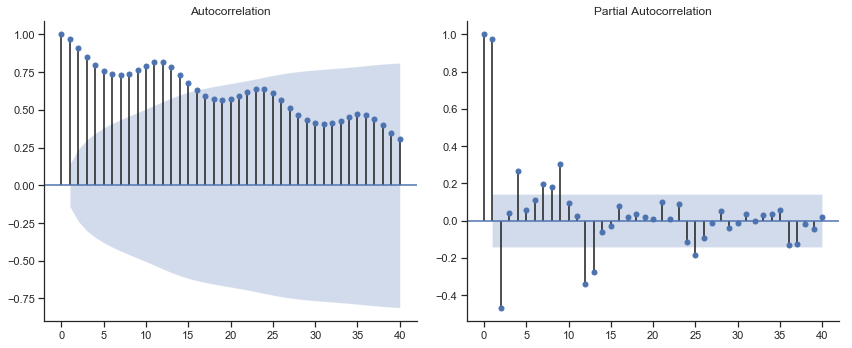

In [17]:
acf_pacf_plot(ts);

### We clearly see that there is Trend and monthly Seasonality in our Time Series data as we can see in the ACF plot which confirms the result from the Dicky Fuller test

### So let's make our time series Stationary

#### One important point to note here- We do differencing to actually fit the ARIMA model, but just to see which p,d and q value will give the best residual(with no significant correlated values) and using those values we fit our ARIMA model on our original data values

#### This point is very important here, that we do make our TS stationary and and perform all the test and seeing the ACF and PACF plot, find the best p,d and q values. But our actual modelling is done on original values that are to be forecasting.

#### We might have to do transformation to reduce the trend, or reduce multiplicity of the seasonality. These transformation can be log, sq-rt, cube root etc. Basically it penalizes larger values more than the smaller.

### Now for making TS stationary, we first do seasonal differencing

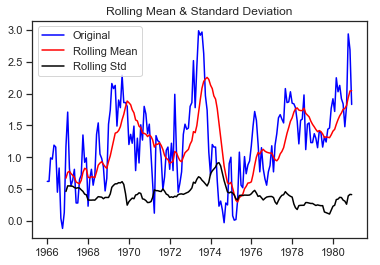

Results of Dickey-Fuller Test:
Test Statistic                  -2.820219
p-value                          0.055443
#Lags Used                      14.000000
Number of Observations Used    165.000000
Critical Value (1%)             -3.470616
Critical Value (5%)             -2.879221
Critical Value (10%)            -2.576197
dtype: float64


In [18]:
df=pd.DataFrame(y.copy())
sdiff=y-y.shift(12)
#df.drop(['original'],axis=1).dropna()
sdiff=sdiff.dropna()
sdiff.index=sdiff.index.to_timestamp(freq='ns')
test_stationarity(sdiff)

### Now we see above, that our p-value is near to the significant value, but we do see our original data still showing some variability in it.

### Let's see the ACF and PACF plot for this data

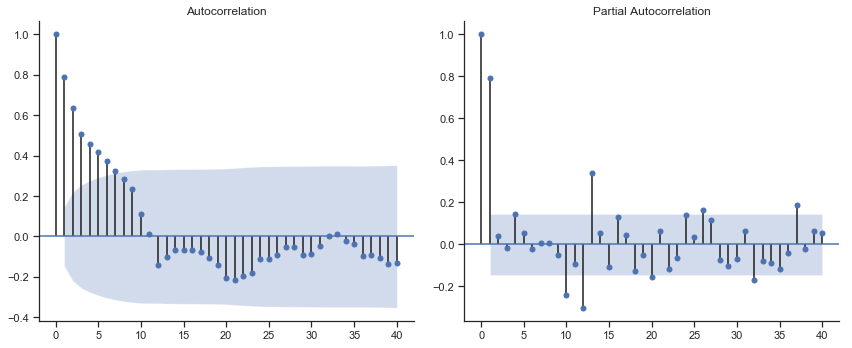

In [19]:
acf_pacf_plot(sdiff);

### And with so many significant Autocorrelation values in the first few lags, we infer that our seasonally differenced time series is still not stationary.

### So on the seasonally differenced data, let's perform first differencing

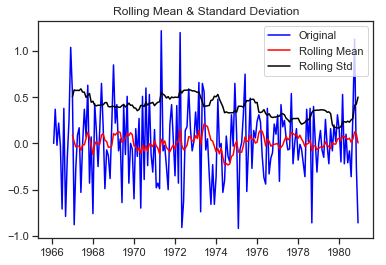

Results of Dickey-Fuller Test:
Test Statistic                  -5.209254
p-value                          0.000008
#Lags Used                      12.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64


In [20]:
diff=sdiff-sdiff.shift()
#df.drop(['original'],axis=1).dropna()
diff=diff.dropna()
#diff.index=diff.index.to_timestamp(freq='ns')
test_stationarity(diff)

### And the ACF, PACF plot is:

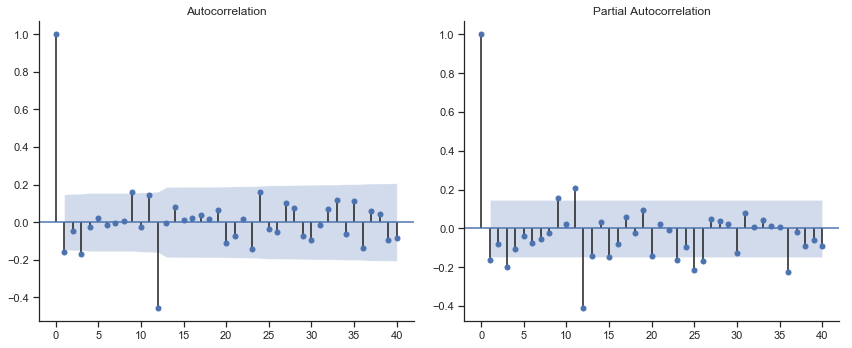

In [21]:
acf_pacf_plot(diff);

### So our Time Series is finally Stationary. Now looking at the model we will now try to fit an ARIMA model.

#### Choosing the p,q value is not an easy task. Moreover the various implications of choosing these values are also very complicated in actual scenario. I can clearly tell that if we fit a non-seasonal ARIMA, then (0,1,1) model will fit perfectly to our actual data(d=1 as we have done first differencing). With a seasonal form, (0,1,1) and (0,1,1)12 will fit this model pretty well.

#### Coming to such conclusions need subject matter expertise and thorough knowledge. I can go on and state all the rules for selecting p,d and q values but they are so many, that I'd suggest you to go through them in this link:

https://people.duke.edu/~rnau/arimrule.htm

#### And if you want more detailed explanation for those rules, go through the other chapters mentioned at the top of the webpage above

### So well, let's fit the ARIMA model to our differenced data and see the residuals and if it they fit well, then let's fit it to forecast for our original time series

### NOTE- An important point to note, while checking if model fits differenced data, don't add differenced part to ARIMA model; that is added while fitting in the original data. You can see though I've differenced earlier, but I am not mentioning it below. But while fitting to the original, I'll use it. Always remember this :D

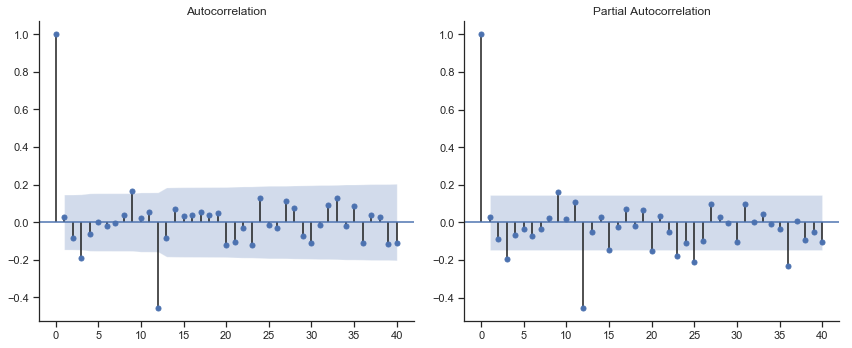

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 co2ppm   No. Observations:                  179
Model:                     ARMA(0, 1)   Log Likelihood                 -90.626
Method:                       css-mle   S.D. of innovations              0.401
Date:                Sun, 23 Dec 2018   AIC                            187.252
Time:                        23:23:11   BIC                            196.814
Sample:                    02-01-1966   HQIC                           191.129
                         - 12-01-1980                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0077      0.023      0.330      0.742      -0.038       0.054
ma.L1.co2ppm    -0.2200      0.091     -2.412      0.017      -0.399      -0.041
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            4.5445           +0.0000j            4.5445            0.0000
-----------------------------------------------------------------------------
"""

In [22]:
arima = sm.tsa.ARIMA(diff, order=(0, 0, 1)).fit()
acf_pacf_plot(arima.resid)
plt.show()
arima.summary()

### Now as we see our model's residuals seem almost white noise, but there is still a significant spike at lag 3 and lag 12 in both ACF and PACF plot.

### If you read the rules from the link in the last markdown, by now you would know that if residual ACF and PACF plots aren't white noise, then maybe we have have underdifferenced our Time Series or not incorporated it in our model. Which exactly what we haven't done. Since we aren't incorporating seasonal part in our ARIMA. Well, let's give that a try as well

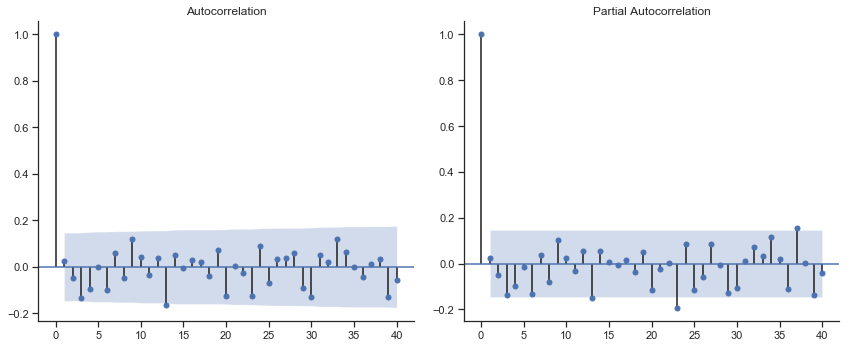

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             co2ppm   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                 -55.805
Date:                            Sun, 23 Dec 2018   AIC                            117.610
Time:                                    23:23:39   BIC                            127.172
Sample:                                02-01-1966   HQIC                           121.488
                                     - 12-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3304      0.063     -5.225      0.000      -0.454      -0.206
ma.S.L12      -0.8582      0.085    -10.086      0.000      -1.025      -0.691
sigma2         0.0999      0.009     10.514      0.000       0.081       0.118
===================================================================================
Ljung-Box (Q):                       45.34   Jarque-Bera (JB):                 7.31
Prob(Q):                              0.26   Prob(JB):                         0.03
Heteroskedasticity (H):               0.92   Skew:                             0.36
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
sarima=sm.tsa.statespace.SARIMAX(diff, order=(0, 0, 1), seasonal_order=(0, 0, 1, 12)).fit()
acf_pacf_plot(sarima.resid)
plt.show()
sarima.summary()

#### Well, you see? Seasonal ARIMA fits perfectly for this data, well obviously because Seasonality is there in it. We also see that accuracy measure i.e. AIC value for SARIMA is way way better than the ARIMA model

#### Now this is the good time to mention, Statsmodel's Statespace module has this Automatic order identifying tool as well, which identifies, which SARIMA model fit's our Time Series data perfectly. Let's try it out and see it's results:

#### Point to note- we perform this on original data

In [24]:
results=sm.tsa.x13_arima_select_order(y)
print(results.order) # non-seasonal part
print(results.sorder) # seasonal part

(0, 1, 1)
(0, 1, 1)


### And you see, it told us the same result that we ended up with(remember we will add d=1 and D=1 while fitting ARIMA on original dataset)

### So if you are not into the idea of learning all the complications of ARIMA and how to find p,d and q. I'll suggest you to try the automated form and then apply the values obtained directly to fit your model and get good forecasts.

In [25]:
sarima=sm.tsa.statespace.SARIMAX(ts, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             co2ppm   No. Observations:                  192
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -55.805
Date:                            Sun, 23 Dec 2018   AIC                            117.610
Time:                                    23:24:47   BIC                            127.172
Sample:                                01-01-1965   HQIC                           121.488
                                     - 12-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3304      0.063     -5.225      0.000      -0.454      -0.206
ma.S.L12      -0.8582      0.085    -10.086      0.000      -1.025      -0.691
sigma2         0.0999      0.009     10.513      0.000       0.081       0.118
===================================================================================
Ljung-Box (Q):                       45.34   Jarque-Bera (JB):                 7.31
Prob(Q):                              0.26   Prob(JB):                         0.03
Heteroskedasticity (H):               0.92   Skew:                             0.36
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Now let's see how the residuals from our model look like alongwith the fitted model

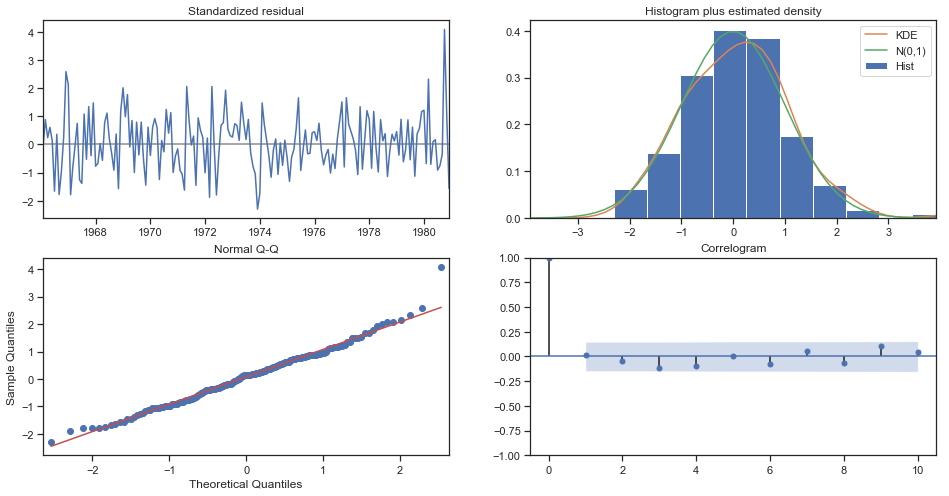

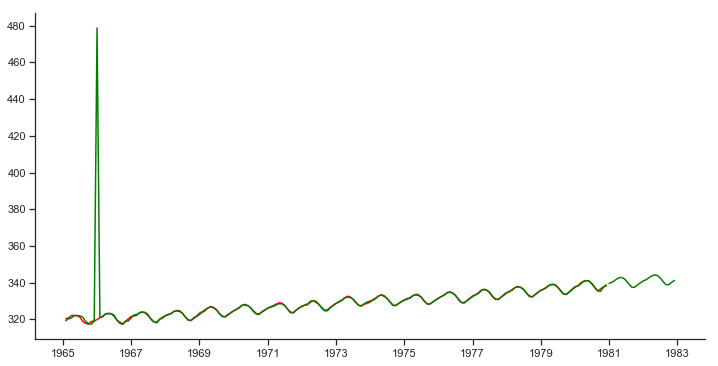

In [26]:
#Residual plots
sarima.plot_diagnostics(figsize=(16,8))

#Our original and fitted plot
fig, ax= plt.subplots(figsize=(12,6))
y[1:].plot(color='red', ax=ax)
sarima.fittedvalues[1:].plot(color='green', ax=ax)
y_pred = sarima.forecast(steps=24)
y_pred.plot(color='green', ax=ax)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

### I'll be honest here and say that I've no idea why our fitted values for 1966-Jan is fitted so high but beside that every other fit looks absolutely right and yes I cross-checked the values of same SARIMA in R and the values are same beside this weird value for 1966-Jan. Maybe it's some internal issue with my machine. So can't reall tell.

### But our residuals are perfect white noise and this model fits our data perfectly. Let me try to visualize them after that peculiear fitted value:

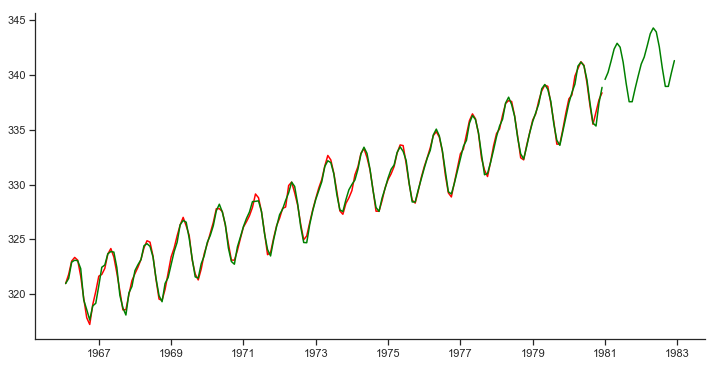

In [27]:
fig, ax= plt.subplots(figsize=(12,6))
y[13:].plot(color='red', ax=ax)
sarima.fittedvalues[13:].plot(color='green', ax=ax)
y_pred = sarima.forecast(steps=24)
y_pred[:].plot(color='green', ax=ax)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

### So you see, this seems to be a really good forecast and prediction. One might wonder why is there a gap in the forecasted area and original data. Well because I am plotting it separately and it starts from the next period. Well we can just append forecast values to the fit value to make it perfect then. So let's do that:

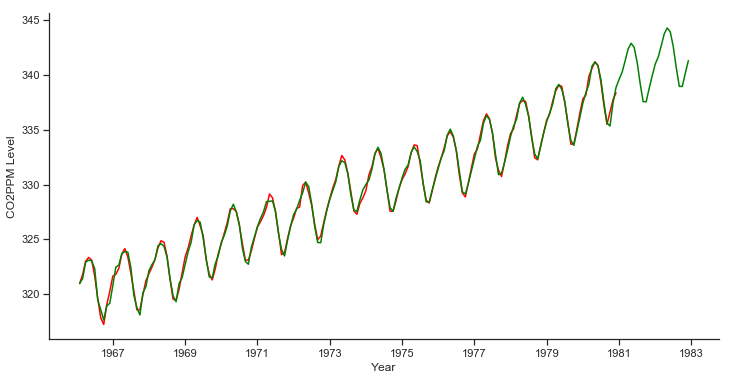

In [28]:
fig, ax= plt.subplots(figsize=(12,6))
y[13:].plot(color='red', ax=ax)
y_pred = sarima.forecast(steps=24)
sarima.fittedvalues[13:].append(y_pred).plot(color='green', ax=ax)
ax.set_xlabel('Year')
ax.set_xticks([], minor=True)
ax.set_ylabel('CO2PPM Level')
sns.despine()
plt.show()

### We can do further graphical changes to add legend and all, but well, you get the gist right. So that's it for now.¶